# Analysis and display of water quality indicators along Greenup pool of Ohio River

<h3>Quick index:</h3>
<ul>
    <li><a href=#map>Map</a></li>
    <li><a href=#transect_plots>Transect Plots</a></li>
    <li><a href=#transect_3d_profiles>Transect 3D Profiles</a></li>
    <li><a href=#ironton_usgs_plots>USGS Gage at Ironton</a></li>
    <li><a href=#locks_plots>Sonde data at RCBI and Greenup Locks</a></li>    </ul>

#### TODO:
* Do timeseries data first, then transects using dynamically generated 2D (RMI x 6H-means) baseline data from Locks
* **NWS** (weather) data
* **WQP** data
* **Chlorophyll** and **algal counts** from grab sample analyses
* WV DEP data (TAGIS)
* Other SENSE/AFI data (sediment data from Booner tubes)
* Plots in **marker popups**
* Shorten/trim column names in sonde_deployments CSV files
* Put all local data in a **database** and access from there
* Create a **dashboard** view for publishing
* Get **PAR** data from Locks
* **ORSANCO** data (from Tom Jones):
 * More **sediment composition** plots:
   * Add distribution plots, correlation plots, multiple-Z plots on same graph
 * Do same for **Fish populations, Macro invertebrates, Substrate types, Water quality**
 * Cross correlations between any pair

## == Get things set up ==

### To install packages locally (e.g., folium, geopandas, fiona, shapely):
```
%%bash -l
use -e -r anaconda3-5.1
pip install folium --prefix=. --upgrade-strategy only-if-needed
```

#### To access them:
```
import os, sys
sys.path.insert(0,'lib/python3.7/site-packages') # Add locally installed packages to path
```

### Use full width of browser window

In [354]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Enable R-style DataFrames with Pandas, numerical arrays and matrices with NumPy

In [355]:
import pandas as pd
import numpy as np

### Enable Math functions

In [356]:
import math

### Enable working with Dates and Times

In [357]:
import time

### Enable Pandas scatter plot matrices

In [358]:
from pandas.plotting import scatter_matrix

### Enable inline MATLAB-style plotting with MatPlotLib

In [359]:
import matplotlib.pyplot as plt
%matplotlib inline

### Enable 3D plotting in MatPlotLib using MPlot3D toolkit

In [360]:
from mpl_toolkits.mplot3d import Axes3D

### Enable interactive plots using iPyWidgets

In [361]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

### Enable geospatial DataFrames with GeoPandas (built on Fiona, which is built on GDAL/OGR)

In [362]:
import geopandas as gpd

### Enable Leatlet.JS-based mapping with Folium 

In [363]:
import folium
from folium import IFrame
import folium.plugins as plugins

### Enable additional HTML features with Branca

In [364]:
import branca

### Enable other geospatial utilities with Shapely

In [365]:
import shapely
from shapely.geometry import Point

# == Sampling Sites ==

### Get all sampling sites along Greenup Pool of Ohio River
#### TODO:
 * Add CSO positions

In [366]:
all_sites = pd.read_csv('data/Greenup/Ohio River Sites.csv')
all_site_geometries = gpd.GeoSeries(all_sites.apply(lambda z: Point(z['Longitude'],z['Latitude']),1),crs={'init':'epsg:4326'})
all_sites = gpd.GeoDataFrame(all_sites.drop(['Latitude','Longitude'],1),geometry=all_site_geometries)
#all_sites

### Generate map of all sampling sites

In [367]:
ohio_map = folium.Map([38.6, -82.5],zoom_start=10,tiles=None)

#### TODO: 
 * Look into **branca.element.IFrame** to preprocess HTML into IFrame -- construct a graph!
 * User Folium **MarkerCluster** and **FeatureGroup** to reduce number of markers (on Zoom out) and turn on/off different marker layers
 * Look at folium.plugins **HeatMap** and **HeatMapWithTime** -- only good for density, not property values!

In [368]:
for i, row in all_sites.iterrows():
    coord = [row.geometry.y,row.geometry.x]
    label = row.Type+' @ '+row.Name
    marker_type = 'pin'
    radius = 3
    color = 'red'
    # Available colors: red, darkred, lightred, pink, green, darkgreen, lightgreen, blue, darkblue, lightblue, cadetblue, purple, darkpurple, orange, beige, black, gray, lightgray
    icon = 'dashboard'
    html = label
    width = 500
    height = 90
    max_width = 1000
    nav_params = '?distance=100'
    if (row.Type == 'Transect'):
        color = 'red'
        html += '<br>'+row.Description
    elif (row.Type == 'USGS Gage'):
        if (row.Name == 'Huntington'):
            nwis_site_json = gpd.read_file("https://cida.usgs.gov/nldi/nwissite/USGS-0{0:.0f}".format(row['USGS Code']))
            comid = nwis_site_json.comid[0]
            comid_url = "https://cida.usgs.gov/nldi/comid/"+comid
            #folium.GeoJson(nwis_site_json,name="NLDI USGS Gage",show=False).add_to(ohio_map)
            folium.GeoJson(comid_url+"/basin",name="Drainage Basin for USGS-0{0:.0f}".format(row['USGS Code']),show=False).add_to(ohio_map)
            folium.GeoJson(comid_url+"/navigate/UM",name="Upstream Main",show=False).add_to(ohio_map)
            folium.GeoJson(comid_url+"/navigate/UT"+nav_params,name="Tributaries Upstream",show=False).add_to(ohio_map)
            folium.GeoJson(comid_url+"/navigate/UM/nwissite"+nav_params,name="NWIS Sites Upstream Main",show=False).add_to(ohio_map)
            folium.GeoJson(comid_url+"/navigate/UM/huc12pp"+nav_params,name="HUC12 Pour Points Upstream Main",show=False).add_to(ohio_map)
            folium.GeoJson(comid_url+"/navigate/UM/wqp"+nav_params,name="WQP Stations Upstream Main",show=False).add_to(ohio_map)
            folium.GeoJson(comid_url+"/navigate/DM",name="Downstream Main",show=False).add_to(ohio_map)
            folium.GeoJson(comid_url+"/navigate/DD"+nav_params,name="Downstream Diversions",show=False).add_to(ohio_map)
            folium.GeoJson(comid_url+"/navigate/DM/nwissite"+nav_params,name="NWIS Sites Downstream Main",show=False).add_to(ohio_map)
            folium.GeoJson(comid_url+"/navigate/DM/huc12pp"+nav_params,name="HUC12 Pour Points Downstream Main",show=False).add_to(ohio_map)
            folium.GeoJson(comid_url+"/navigate/DM/wqp"+nav_params,name="WQP Stations Downstream Main",show=False).add_to(ohio_map)
        if (row.Name == 'Greenup'):
            nwis_site_url = "https://cida.usgs.gov/nldi/nwissite/USGS-0{0:.0f}".format(row['USGS Code'])
            nwis_site_json = gpd.read_file(nwis_site_url)
            folium.GeoJson(nwis_site_url+"/basin",name="Drainage Basin for USGS-0{0:.0f}".format(row['USGS Code']),show=False).add_to(ohio_map)
            folium.GeoJson(nwis_site_url+"/navigate/UT/huc12pp"+nav_params,name="HUC12 Pour Points Upstream Tributaries",show=False).add_to(ohio_map)
            folium.GeoJson(nwis_site_url+"/navigate/UT/wqp"+nav_params,name="WQP Stations Upstream Tributaries",show=False).add_to(ohio_map)
        marker_type = 'circle'
        radius = 5
        color = 'green'
        fill = True
        fill_color = color
        html += '<br><a href=\"https://waterdata.usgs.gov/monitoring-location/0{0:.0f}'.format(row['USGS Code'])+'\",target=\"_blank\">Site info for USGS Gage: 0{0:.0f}'.format(row['USGS Code'])+'</a>'
        html += '<br><a href=\"https://waterdata.usgs.gov/nwis/uv?site_no=0{0:.0f}'.format(row['USGS Code'])+'\",target=\"_blank\">Data for USGS Gage: 0{0:.0f}'.format(row['USGS Code'])+'</a>'
        width = 1000
        height = 500
    elif (row.Type == 'Locks and Dam'):
        marker_type = 'circle'
        radius = 5
        color = 'red'
        fill = True
        fill_color = color
        html += '<br><a href=\"https://www.lrh.usace.army.mil/Missions/Civil-Works/Locks-and-Dams/{0:s}'.format(row['USACE Code'])+'\",target=\"_blank\">Data for Locks and Dams at {0:s}'.format(row['Name'])+'</a>'
    elif (row.Type == 'ORSANCO'):
        marker_type = 'circle'
        radius = 5
        color = 'orange'
        fill = True
        fill_color = color
    elif (row.Type == 'Sampling'):
        marker_type = 'circle'
        radius = 3
        color = 'blue'
        fill = True
        fill_color = color
    else:
        continue
    html += '<br>Lat: {0:.2f}'.format(row.geometry.y)+', Lon: {0:.2f}'.format(row.geometry.x)
    html += '<br>RMI: {0:.1f}'.format(row.RMI)
    iframe = folium.IFrame(html,width=width,height=height)
    popup = folium.Popup(iframe,max_width=max_width)
    if (marker_type == 'pin'):
        folium.Marker(location=coord,icon=folium.Icon(color=color,icon=icon),popup=popup,tooltip=label).add_to(ohio_map)
    elif (marker_type == 'circle'):
        folium.CircleMarker(location=coord,radius=radius,color=color,popup=popup,tooltip=label).add_to(ohio_map)
    else:
        continue

#### Add the builtin OpenStreetMap and Stamen Terrain basemaps

In [369]:
folium.TileLayer('OpenStreetMap').add_to(ohio_map)
folium.TileLayer('StamenTerrain').add_to(ohio_map)

#### Add other basemap options using Map Servers at  ArcGIS Online

In [370]:
mapserver_query = '/MapServer/tile/{z}/{y}/{x}'
ESRI = dict(NatGeo_World_Map='http://services.arcgisonline.com/arcgis/rest/services/NatGeo_World_Map/MapServer',
            World_Imagery='http://services.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer',
            World_Shaded_Relief='http://services.arcgisonline.com/arcgis/rest/services/World_Shaded_Relief/MapServer',
            World_Street_Map='http://services.arcgisonline.com/arcgis/rest/services/World_Street_Map/MapServer',
            World_Topo_Map='http://services.arcgisonline.com/arcgis/rest/services/World_Topo_Map/MapServer',
            World_Hydro_Reference='http://hydrology.esri.com/arcgis/rest/services/WorldHydroReferenceOverlay/MapServer')

for tile_name, tile_url in ESRI.items():
    tile_url += mapserver_query
    folium.TileLayer(tile_url,name=tile_name,attr=tile_name).add_to(ohio_map)

#### Add HUC boundaries 
 * First example converts a HUC10 .shp file to GeoJSON
 * Second example streams GeoJSON from the USGS National Map (NHDPlus) HUC12 Web Service using bounding box (envelope)

In [371]:
#wbdhu10 = gpd.read_file("data/Greenup/WBDHU10.shp").to_crs(epsg='4326').to_json()
#folium.GeoJson(wbdhu10,name="WBD HUC10",show=False).add_to(ohio_map)
folium.GeoJson("https://hydro.nationalmap.gov/arcgis/rest/services/NHDPlus_HR/MapServer/11/query?where=&text=&objectIds=&time=&geometry=-83%2C38.4%2C-82%2C38.7&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&relationParam=&outFields=&returnGeometry=true&returnTrueCurves=false&maxAllowableOffset=&geometryPrecision=&outSR=&having=&returnIdsOnly=false&returnCountOnly=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&returnZ=false&returnM=false&gdbVersion=&historicMoment=&returnDistinctValues=false&resultOffset=&resultRecordCount=&queryByDistance=&returnExtentOnly=false&datumTransformation=&parameterValues=&rangeValues=&quantizationParameters=&f=geojson",show=False,name='HUC12 Boundararies').add_to(ohio_map)

#### Add Streams 
 * Why do only certain segments appear?

In [372]:

#folium.GeoJson("https://hydro.nationalmap.gov/arcgis/rest/services/NHDPlus_HR/MapServer/2/query?where=FTYPE%3D460&text=&objectIds=&time=&geometry=-83%2C38.4%2C-82%2C38.7&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&relationParam=&outFields=&returnGeometry=true&returnTrueCurves=false&maxAllowableOffset=&geometryPrecision=&outSR=&having=&returnIdsOnly=false&returnCountOnly=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&returnZ=false&returnM=false&gdbVersion=&historicMoment=&returnDistinctValues=false&resultOffset=&resultRecordCount=&queryByDistance=&returnExtentOnly=false&datumTransformation=&parameterValues=&rangeValues=&quantizationParameters=&f=geojson",show=False,name='Streams').add_to(ohio_map)

#### Add raster (image) overlayers
 * DEM: USGS National Elevation Dataset (NED)
 
#### TODO:
 * More DEM (NED) tiles
 * Land Cover / Use
 * Soil Type
 * Satellite (MODUS)

In [373]:
folium.raster_layers.ImageOverlay("data/Greenup/ned19_n38x50_w082x50_wv_statewide_2003_thumb.jpg",bounds=[[38.25,-82.50],[38.5,-82.25]],opacity=0.5,name="NED",show=False).add_to(ohio_map)

#### Add the Layer Control widget

In [374]:
folium.LayerControl().add_to(ohio_map)

#### Save the map as HTML and display it
 * Suppress before publishing as read-only Tool

<div id='map' />

## Map

In [375]:
ohio_map.save('ohio_map.html')

In [376]:
from IPython.display import IFrame
IFrame("ohio_map.html", width=1000, height=500)

## == Transects ==

### Read in CSV-formatted table of geo-tagged and time-stamped sensor data from the transects into a DataFrame

#### Get Sonde data

In [377]:
transects_sonde = pd.read_csv('data/Greenup/All Transects_Sonde.csv',encoding='latin1')

#### Get PAR data

In [378]:
transects_par = pd.read_csv('data/Greenup/All Transects_PAR.csv',encoding='latin1')

#### Parse out Horizontal and Vertical position codes along transect

In [379]:
transects_sonde['H Code'] = transects_sonde['Site Name'].apply(lambda x: x[0])
transects_sonde['V Code'] = transects_sonde['Site Name'].apply(lambda x: x[1:])

In [380]:
transects_par['H Code'] = transects_par['SITE'].apply(lambda x: x[0])
transects_par['V Code'] = transects_par['SITE'].apply(lambda x: x[1:])

#### Create Data-Time field from Date and Time fields

In [381]:
def datetime_sonde(row):
    pattern = '%m/%d/%Y-%H:%M:%S'
    dt = row['Date (MM/DD/YYYY)']+'-'+row['Time (HH:MM:SS)']
    return pd.to_datetime(time.mktime(time.strptime(dt,pattern)),unit='s')
    
transects_sonde['Date-Time'] = transects_sonde.apply(lambda row: datetime_sonde(row),axis=1)

In [382]:
def datetime_par(row):
    pattern = '%m/%d/%Y-%I:%M:%S %p'
    dt = row['Date']+'-'+row['Time']
    return pd.to_datetime(time.mktime(time.strptime(dt,pattern)),unit='s')
    
transects_par['Date-Time_par'] = transects_par.apply(lambda row: datetime_par(row),axis=1)

#### Filter out Test samples from Sonde data 
 * TODO: Consider dropping in place

In [383]:
transects_sonde = transects_sonde[transects_sonde['Site Name'].str.contains('Test')==False]

#### Convert Transect and Horizontal positions to numbers

In [384]:
transects_sonde['T Pos'] = transects_sonde['Transect'].apply(lambda x: int(x[2:]))
transects_sonde['H Pos'] = transects_sonde['H Code'].apply(lambda x: int(x))

In [385]:
transects_par['T Pos'] = transects_par['Transect'].apply(lambda x: int(x[2:]))
transects_par['H Pos'] = transects_par['H Code'].apply(lambda x: int(x))

#### Filter out non-data, empty columns (like TSS) and reduntant columns (like chlorophyll, BGA, conductivity, pH, and depth)

In [386]:
transects_sonde_dataonly = transects_sonde.drop(transects_sonde.columns[:8],axis=1).drop(['H Code','TSS mg/L'],axis=1) \
    .drop(['ODO % sat','Chlorophyll RFU','BGA-PC RFU','pH mV','Press psi a'],axis=1) \
    .drop(transects_sonde.columns[[16,18,19]],axis=1)

In [387]:
transects_par_dataonly = transects_par.drop(transects_par.columns[:3],axis=1).drop(['H Code','BATT','SITE','CHK','Date-Time_par'],axis=1) \
    .drop(['PAR_MAX','PAR_MIN'],axis=1)

#### Create 3-part Index from T, H, and V values to help join Sonde and PAR data
 * Only keep one set of original columns (Sonde)

In [388]:
transects_sonde_dataonly = transects_sonde_dataonly.set_index(['T Pos','H Pos','V Code'],drop=False)

In [389]:
transects_par_dataonly = transects_par_dataonly.set_index(['T Pos','H Pos','V Code'],drop=True)

#### Combine (merge/join) Sonde and PAR data using new index
 * Get rid of 'V Code' column, which is no longer needed

In [390]:
transects_combined = pd.merge(transects_sonde_dataonly,transects_par_dataonly,left_index=True,right_index=True).drop(['V Code'],axis=1)

#### Create column for Chlorophyll / BGA ratio 
 * Fix ranges first to keep numerator positive and denominator > zero

In [391]:
transects_combined['Chlorophyll µg/L'] = transects_combined['Chlorophyll µg/L'].apply(lambda x: 0.0 if x < 0.0 else x)

In [392]:
transects_combined['BGA-PC µg/L'] = transects_combined['BGA-PC µg/L'].apply(lambda x: 0.1 if x < 0.1 else x)

In [393]:
transects_combined['Chlorophyll/BGA'] = transects_combined.apply(lambda x: x['Chlorophyll µg/L']/x['BGA-PC µg/L'], axis=1)
#transects_combined.head()

#### Merge in location data, including RMI
 * Create temporary matching Name column (from 'T Pos') for merging
 * Drop all unnecessary columns

In [394]:
transects_combined['Name'] = transects_combined['T Pos'].apply(lambda x: 'T-'+str(x))
transects_combined = pd.merge(transects_combined,all_sites,on=['Name']).drop(all_sites.columns[0:5],axis=1).drop(all_sites.columns[6:],axis=1)
#transects_combined.columns

#### Re-index by datetime

In [395]:
transects_combined = transects_combined.set_index(['Date-Time'])
#transects_combined.columns

<div id='transect_plots'></div>

## Transect Plots

### Distribution plots of transect data

In [396]:
def dist_plot(Property,Kind='kde'):
    transects_combined[Property].plot(kind=Kind)
    
interact(dist_plot, \
         Property=transects_combined.columns.drop(['T Pos','H Pos','RMI']), \
         Kind=['hist','kde','box'] \
        )

interactive(children=(Dropdown(description='Property', options=('ODO mg/L', 'Chlorophyll µg/L', 'BGA-PC µg/L',…

<function __main__.dist_plot(Property, Kind='kde')>

### Correlation Scatter Plots

#### Scatter matrix for all properties (disabled due to size)

In [397]:
#scatter_matrix(transects_combined,figsize=(20.0,20.0),diagonal='kde')

#### Individual scatter plots (3rd property used for color map)

In [398]:
def scatter_plot_transects(YProperty=transects_combined.columns[0],XProperty=transects_combined.columns[1],CProperty=transects_combined.columns[3],ColorMap='jet'):
    fig, ax = plt.subplots()
    transects_combined.plot.scatter(ax=ax,x=XProperty,y=YProperty,c=CProperty,cmap=ColorMap,s=4)
    ax.set_title("Correlation of "+YProperty+" and "+XProperty,fontsize=14)
    
interact(scatter_plot_transects, \
         YProperty=transects_combined.columns, \
         XProperty=transects_combined.columns, \
         CProperty=transects_combined.columns, \
         ColorMap=['jet','viridis','magma','coolwarm','seismic','Greys','Reds','Blues'] \
        )

interactive(children=(Dropdown(description='YProperty', options=('ODO mg/L', 'Chlorophyll µg/L', 'BGA-PC µg/L'…

<function __main__.scatter_plot_transects(YProperty='ODO mg/L', XProperty='Chlorophyll µg/L', CProperty='Temp °C', ColorMap='jet')>

### Use scatter plot to display depth x width profile for selected transect with data points colored by value of selected property

In [399]:
def transect_profile_plot(Transect,Property,ColorMap='jet'):
    fig, ax = plt.subplots()
    transect = transects_combined[transects_combined['T Pos']==Transect]
    transect.plot.scatter(ax=ax,x='H Pos',y='Depth m',ylim=(15,0),c=Property,cmap=ColorMap,marker='H',s=250,xticks=[])
    ax.set_title("Transect Profile for "+Property,fontsize=14)
    ax.set(ylabel="Depth",xlabel="Cross-River Position")
    
interact(transect_profile_plot, \
         Transect=transects_combined['T Pos'].unique(), \
         Property=transects_combined.columns.drop(['Depth m','T Pos','H Pos','PAR','RMI']), \
         ColorMap=['jet','viridis','magma','coolwarm','seismic','Greys','Reds','Blues'] \
        )

interactive(children=(Dropdown(description='Transect', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

<function __main__.transect_profile_plot(Transect, Property, ColorMap='jet')>

### Loop through all the data columns to create a profile panel

In [400]:
def transect_profile_panel(Transect,ColorMap='jet'):
    fig, ax = plt.subplots(nrows=2,ncols=5,figsize=(25,10))
    transect = transects_combined[transects_combined['T Pos']==Transect]
    i = j = 0
    for col in transects_combined.columns[:13].drop(['T Pos','H Pos','Depth m']):
        transect.plot.scatter(ax=ax[j,i],x='H Pos',y='Depth m',ylim=(14,0),c=col,cmap=ColorMap,marker='H',s=250)
        ax[j,i].axis('off')
        if i < 4:
            i = i + 1
        else:
            i = 0
            j = j + 1
            
interact(transect_profile_panel, \
         Transect=transects_combined['T Pos'].unique(), \
         ColorMap=['jet','viridis','magma','coolwarm','seismic','Greys','Reds','Blues'] \
        )

interactive(children=(Dropdown(description='Transect', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

<function __main__.transect_profile_panel(Transect, ColorMap='jet')>

### Get transect means and baseline values from corresponding measurements at the RC Byrd and Greenup Locks and Dams
#### (Previously generated from resampled time series data below, merge_all_means)

In [401]:
transects_means_bases = pd.read_csv('data/Greenup/transects_with_bases.csv',encoding='latin1')

In [402]:
transects_means_bases = transects_means_bases.drop(['ODO % sat_mean', 'ODO % sat_base', \
    'Chlorophyll RFU_mean', 'Chlorophyll RFU_base', \
    'BGA-PC RFU_mean', 'BGA-PC RFU_base', \
    'SpCond µS/cm_mean', 'SpCond µS/cm_base', \
    'nLF Cond µS/cm_mean', 'nLF Cond µS/cm_base', \
    'TDS mg/L_mean', 'TDS mg/L_base', \
    'pH mV_mean', 'pH mV_base', \
    'PAR_mean', 'PAR_MIN_mean', 'PAR_MAX_mean', \
    'ODO % sat_RCB', 'Chlorophyll RFU_RCB', 'BGA-PC RFU_RCB', 'SpCond ÂµS/cm_RCB', 'nLF Cond ÂµS/cm_RCB', 'TDS mg/L_RCB', 'pH mV_RCB', 'Press psi a_RCB', \
    'ODO % sat_Greenup', 'Chlorophyll RFU_Greenup', 'BGA-PC RFU_Greenup', 'SpCond ÂµS/cm_Greenup', 'nLF Cond ÂµS/cm_Greenup', 'TDS mg/L_Greenup', 'pH mV_Greenup', 'Press psi a_Greenup'],axis=1)
transects_means_bases.columns

Index(['T Pos', 'ODO mg/L_mean', 'ODO mg/L_base', 'Chlorophyll µg/L_mean',
       'Chlorophyll µg/L_base', 'BGA-PC µg/L_mean', 'BGA-PC µg/L_base',
       'Temp °C_mean', 'Temp °C_base', 'Cond µS/cm_mean', 'Cond µS/cm_base',
       'Sal psu_mean', 'Sal psu_base', 'Turbidity NTU_mean',
       'Turbidity NTU_base', 'pH_mean', 'pH_base', 'ODO mg/L_RCB',
       'Chlorophyll Âµg/L_RCB', 'BGA-PC Âµg/L_RCB', 'Temp Â°C_RCB',
       'Cond ÂµS/cm_RCB', 'Sal psu_RCB', 'Turbidity NTU_RCB', 'pH_RCB',
       'Depth m_RCB', 'ODO mg/L_Greenup', 'Chlorophyll Âµg/L_Greenup',
       'BGA-PC Âµg/L_Greenup', 'Temp Â°C_Greenup', 'Cond ÂµS/cm_Greenup',
       'Sal psu_Greenup', 'Turbidity NTU_Greenup', 'pH_Greenup',
       'Depth m_Greenup'],
      dtype='object')

In [403]:
transects_means_bases['Chlorophyll/BGA_mean'] = transects_means_bases.apply(lambda x: x['Chlorophyll µg/L_mean']/x['BGA-PC µg/L_mean'], axis=1)
transects_means_bases['Chlorophyll/BGA_base'] = transects_means_bases.apply(lambda x: x['Chlorophyll µg/L_base']/x['BGA-PC µg/L_base'], axis=1)

#### Merge with transect data to do baseline corrections and comparisons with means

In [404]:
transects_with_bases = pd.merge(transects_combined,transects_means_bases,on=['T Pos'])
#transects_with_bases.head()

<div id='transect_3d_profiles'></div>

### Create pseudo 3D profile showing all transects

In [405]:
def plot_3d_transects(Property,Type='Absolute',ColorMap='jet',HAng=30,VAng=0):
    fig = plt.figure(figsize=(5,4))
    ax = plt.axes((0.0,0.0,5.0,1.0),projection='3d',title=Property+' '+Type)
    z = -transects_combined['Depth m']
    y = -transects_combined['RMI']
    x = transects_combined['H Pos']
    if (Type == 'Absolute'):
        c = transects_combined[Property]
    elif(Type == 'WRT Baseline'):
        c = (transects_with_bases[Property]-transects_with_bases[Property+'_base'])/transects_with_bases[Property+'_base']
    elif(Type == 'WRT Transect Mean'):
        c = (transects_with_bases[Property]-transects_with_bases[Property+'_mean'])/transects_with_bases[Property+'_mean']
    scat = ax.scatter(x,y,z,c=c,cmap=ColorMap,s=100,marker='H')
    fig.colorbar(scat)
    ax.view_init(HAng,VAng)
    
interact(plot_3d_transects, \
         Property=transects_combined.columns.drop(['Depth m','T Pos','H Pos','PAR','RMI']),
         Type=['Absolute','WRT Baseline','WRT Transect Mean'],
         ColorMap=['jet','viridis','magma','coolwarm','seismic','Greys','Reds','Blues'],
         HAng=(0,90,5),VAng=(-5,5) \
        )

interactive(children=(Dropdown(description='Property', options=('ODO mg/L', 'Chlorophyll µg/L', 'BGA-PC µg/L',…

<function __main__.plot_3d_transects(Property, Type='Absolute', ColorMap='jet', HAng=30, VAng=0)>

#### Test use of Plotly (requires Plotly online account and API key)

```
import plotly
plotly.tools.set_credentials_file(username='jacks9',api_key='BYcXwx33PGIcLI0SW1W9')
import plotly.plotly as py
import plotly.figure_factory as ff
table = ff.create_table(transects_notests)
py.iplot(table,filename='transects-table')
```

## == ORSANCO Data ==

## Sediment Composition

#### TODO: 
 * Distribution plots, Correlation plots, Multiple Z plots on same graph
 * Do same for Fish populations, Macro invertebrates, Substrate types, Water quality
 * Cross correlations between any pair

#### Get Sediment Composition Data (2011)

In [406]:
locations = pd.read_csv('data/Greenup/Ohio River Sites.csv')

In [407]:
sediment_data = pd.read_csv('data/Greenup/GreenupSedimentData2011.csv',encoding='latin1')
sediment_data.rename(columns={'Location':'Name'},inplace=True)
sediment_data_with_lat_lon = pd.merge(sediment_data,locations,on='Name').fillna(0)
#sediment_data_with_lat_lon.columns

#### Plot Sediment Composition vs River Mile

In [408]:
def rmi_plot(Property):
    sediment_data.plot(x='RMI',y=Property)
    
interact(rmi_plot, \
         Property=sediment_data.columns[8::2] \
        )

interactive(children=(Dropdown(description='Property', options=('Solids_DF', 'Moisture_DF', 'LOI_DF', 'NO3_mg_…

<function __main__.rmi_plot(Property)>

#### Generate a Heat Map using Folium plugin

from IPython.display import IFrame
m = folium.Map([38.6,-82.5],zoom_start=10,tiles=None)
folium.TileLayer('OpenStreetMap').add_to(m)
for prop in sediment_data.columns[9::2]:
    sediment_data_with_lat_lon['Heat Value'] = sediment_data_with_lat_lon[prop].apply(lambda x: (x+3.0)/6.0)
    m_data = sediment_data_with_lat_lon[['Latitude','Longitude','Heat Value']].values.tolist()
    plugins.HeatMap(m_data,name=prop,radius=10,gradient={0.4:'lime', 0.5:'blue', 0.6:'red'},blur=5,show=False).add_to(m)
folium.LayerControl().add_to(m)
m.save('heatmap.html')
#sediment_data_with_lat_lon[['Latitude','Longitude','Heat Value']].values.tolist()
IFrame('heatmap.html',width=600,height=500)

## == USGS Gage at Ironton ==

### Get USGS Gage data directly from USGS (WaterData) web services 
 * Gage #03216070 in Ironton, OH
 * TODO
   * Resolve issue with columns being mismatched
   * Move merge (from below) to after reading Locks data and replace discharge values (based on Ironton data)

In [409]:
usgs_gage = pd.read_csv("https://nwis.waterdata.usgs.gov/usa/nwis/uv/"+ \
                        "?site_no=03216070"+ \
                        "&period=&begin_date=2017-08-25&end_date=2019-06-19"+ \
                        "&cb_00010=on&cb_00011=on&cb_00060=on&cb_00065=on&cb_00095=on&cb_00300=on&cb_00400=on&cb_63680=on&cb_72254=on&cb_72255=on&cb_99133=on"+ \
                        "&format=rdb", \
                       sep='\t',comment='#',header=[0,1])

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (11,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [410]:
usgs_gage = usgs_gage.reset_index()
usgs_gage.columns = ['Index', 'Agency', 'Site', 'DateTime', 'TZ', \
                     'Temperature', 'q1', 'Temperature ADVM', 'q2', 'Discharge', 'q3', 'Gage height', 'q4', \
                     'Specific cond', 'q5', 'Dissolved oxygen', 'q6', 'pH', 'q7', 'Turbidity', 'q8', \
                     'Sensor velocity', 'q9', 'Mean velocity', 'q10', 'NO3+NO2', 'q11']
#usgs_gage.columns, usgs_gage.head()

In [411]:
usgs_gage = usgs_gage.drop(usgs_gage.columns[6:28:2],axis=1)
usgs_gage = usgs_gage.drop(['Index','Agency','Site','TZ'],axis=1)
#usgs_gage.head()

In [412]:
def datetime_usgs(row):
    pattern = '%Y-%m-%d %H:%M'
    dt = row['DateTime']
    return pd.to_datetime(time.mktime(time.strptime(dt,pattern)),unit='s')
    
usgs_gage['DateTime'] = usgs_gage.apply(lambda row: datetime_usgs(row),axis=1)
usgs_gage = usgs_gage.set_index(['DateTime'])

<div id='ironton_usgs_plots'></div>

## Ironton Gage Plots
 * TODO:
   * Set NO3+NO2 value to some default (0.0) instead of dropping the columns
   * The data coming from the web service seems **really messed up**, as though columns are out of order
     * Gage height looks for like Temperature
     * Temperature like Discharge
     * Sp Cond like Depth or Discharge
     * Turbidity like Sp Cond
     * Sensor V like DO
     * Mean V like Turbidity
     * But DO and Discharge look OK

In [413]:
def dist_plot_ts_usgs(Property,Kind='kde'):
    usgs_gage[Property].plot(kind=Kind,color='blue')
        
interact(dist_plot_ts_usgs, \
         Property=usgs_gage.columns.drop(['NO3+NO2']), \
         Kind=['hist','kde','box'] \
        )

interactive(children=(Dropdown(description='Property', options=('Temperature', 'Temperature ADVM', 'Discharge'…

<function __main__.dist_plot_ts_usgs(Property, Kind='kde')>

In [414]:
def scatter_plot_timeseries_usgs(YProperty=usgs_gage.columns[0],XProperty=usgs_gage.columns[1],CProperty=usgs_gage.columns[3],ColorMap='jet'):
    fig, ax = plt.subplots()
    usgs_gage.plot.scatter(ax=ax,x=XProperty,y=YProperty,c=CProperty,cmap=ColorMap,s=1)
    ax.set_title("Correlation of "+YProperty+" and "+XProperty,fontsize=14)
    
interact(scatter_plot_timeseries_usgs, \
         YProperty=usgs_gage.columns.drop(['NO3+NO2']), \
         XProperty=usgs_gage.columns.drop(['NO3+NO2']), \
         CProperty=usgs_gage.columns.drop(['NO3+NO2']), \
         ColorMap=['jet','viridis','magma','coolwarm','seismic','Greys','Reds','Blues'] \
        )

interactive(children=(Dropdown(description='YProperty', options=('Temperature', 'Temperature ADVM', 'Discharge…

<function __main__.scatter_plot_timeseries_usgs(YProperty='Temperature', XProperty='Temperature ADVM', CProperty='Gage height', ColorMap='jet')>

In [415]:
from datetime import datetime
start_date = datetime(2017, 8, 1)
end_date = datetime.now()
dates = pd.date_range(start_date, end_date, freq='M')
date_options = [(date.strftime(' %b %Y '), date) for date in dates]
date_index = (0, len(date_options)-1)

date_range_slider = widgets.SelectionRangeSlider(
    options=date_options,
    index=date_index,
    description = "Dates",
    orientation = 'horizontal',
    layout = {'width': '500px'}
)
date_range_slider

SelectionRangeSlider(description='Dates', index=(0, 23), layout=Layout(width='500px'), options=((' Aug 2017 ',…

In [416]:
def plot_ts_usgs(date_range=(start_date,end_date)):
    fig, axes = plt.subplots(nrows=len(usgs_gage.columns)-1,ncols=1,figsize=(20,30),sharex=False)
    i = 0
    for property in usgs_gage.columns.drop(['NO3+NO2']):
        usgs_gage[property].plot(ax=axes[i],drawstyle='steps-post',legend=True,color='blue')
        axes[i].legend([property],loc='upper left')
        axes[i].set_xlim(date_range)
        i = i+1
            
interact_manual(plot_ts_usgs,date_range=date_range_slider)

interactive(children=(SelectionRangeSlider(description='Dates', index=(0, 23), layout=Layout(width='500px'), o…

<function __main__.plot_ts_usgs(date_range=(datetime.datetime(2017, 8, 1, 0, 0), datetime.datetime(2019, 8, 5, 13, 51, 11, 703220)))>

## == Greenup and RCBI Locks ==

### RC Byrd and Greenup Locks and Dams Time Series Data 

#### Get Sonde data
 * Now includes USGS discharge data - based on Ironton gage
 * TODO: remove Ironton discharge data and use USGS web service to get

In [417]:
locks_all = pd.read_csv('data/Greenup/Locks_sonde_data_3.csv',encoding='latin1')

#### Get PAR data

In [418]:
locks_par = pd.read_csv('data/Greenup/Locks_PAR_data.csv',encoding='latin1')

#### Create Date-Time field as index

In [419]:
def datetime(row):
    pattern = '%m/%d/%y-%H:%M:%S'
    dt = row['Date (MM/DD/YYYY)']+'-'+row['Time (HH:MM:SS)']
    return pd.to_datetime(time.mktime(time.strptime(dt,pattern)),unit='s')
    
locks_all['Date-Time'] = locks_all.apply(lambda row: datetime(row),axis=1)
locks_all = locks_all.set_index(['Date-Time'])

In [420]:
def datetime_par(row):
    pattern = '%m/%d/%y-%H:%M:%S %p'
    dt = row['Date']+'-'+row['Time']
    return pd.to_datetime(time.mktime(time.strptime(dt,pattern)),unit='s')
    
locks_par['Date-Time'] = locks_par.apply(lambda row: datetime_par(row),axis=1)
locks_par = locks_par.set_index(['Date-Time'])

#### Filter out Sonde data with zero values for conductivity-related measures (use salinity as indicator)

In [421]:
locks_all = locks_all[locks_all['Sal psu'] != 0]

In [422]:
locks_all['Discharge CFS'] = locks_all['Discharge CFS'].replace(0,np.nan)
locks_all['Chlorophyll µg/L'] = locks_all['Chlorophyll µg/L'].apply(lambda x: 0.0 if x < 0.0 else x)
locks_all['BGA-PC µg/L'] = locks_all['BGA-PC µg/L'].apply(lambda x: 0.1 if x < 0.1 else x)

In [423]:
locks_all['Chlorophyll/BGA'] = locks_all.apply(lambda x: x['Chlorophyll µg/L']/x['BGA-PC µg/L'], axis=1)

#### Drop non-data columns, TSS (all NaN), and redunctant columns (chlorophyll, BGA, conductivity, salinity, pH, depth) from Sonde data
 * TODO: Try using Zip of desired columns instead of dropping everything else

In [424]:
locks_all_dataonly = locks_all.drop(locks_all.columns[:7],axis=1).drop('Wiper Pos V',axis=1) \
    .drop('TSS mg/L',axis=1) \
    .drop('ODO % sat',axis=1).drop('Chlorophyll RFU',axis=1).drop('BGA-PC RFU',axis=1) \
    .drop(locks_all.columns[[15,17,18]],axis=1).drop('Sal psu',axis=1).drop('pH mV',axis=1).drop('Press psi a',axis=1)

In [425]:
rcb_only = locks_all[locks_all['Site Name'].str.contains('RCB')==True]
greenup_only = locks_all[locks_all['Site Name'].str.contains('Greenup')==True]
rcb_dataonly = rcb_only.drop(rcb_only.columns[:7],axis=1).drop('Wiper Pos V',axis=1).drop('TSS mg/L',axis=1)
greenup_dataonly = greenup_only.drop(greenup_only.columns[:7],axis=1).drop('Wiper Pos V',axis=1).drop('TSS mg/L',axis=1)

#### Filter out (truncate) very large PAR values (>2000)

In [426]:
locks_par['PAR_rcb'] = locks_par['PAR_rcb'].apply(lambda x: np.NaN if x > 2000.0 else x)
locks_par['PAR_greenup'] = locks_par['PAR_greenup'].apply(lambda x: np.NaN if x > 2000.0 else x)

### Plots for Sonde and PAR data at Locks 

#### Distribution plots for Sonde data

In [427]:
def dist_plot_ts(Property,Site='RCB',Kind='kde'):
    if ((Site=='RCB') | (Site=='Both')):
        rcb_dataonly[Property].plot(kind=Kind,color='blue')
    if ((Site=='Greenup') | (Site=='Both')):
        greenup_dataonly[Property].plot(kind=Kind,color='green')
        
interact(dist_plot_ts, \
         Property=locks_all_dataonly.columns, \
         Site=['RCB','Greenup','Both'], \
         Kind=['hist','kde','box'] \
        )

interactive(children=(Dropdown(description='Property', options=('ODO mg/L', 'Chlorophyll µg/L', 'BGA-PC µg/L',…

<function __main__.dist_plot_ts(Property, Site='RCB', Kind='kde')>

#### Distribution plots for PAR data

In [428]:
def dist_plot_par(Site='rcb',Kind='kde'):
    if ((Site=='RCB') | (Site=='Both')):
        locks_par["PAR_rcb"].plot(kind=Kind,color='blue')
    if ((Site=='Greenup') | (Site=='Both')):
        locks_par["PAR_greenup"].plot(kind=Kind,color='green')
        
interact(dist_plot_par, \
         Site=['RCB','Greenup','Both'], \
         Kind=['hist','kde','box'] \
        )

interactive(children=(Dropdown(description='Site', options=('RCB', 'Greenup', 'Both'), value='RCB'), Dropdown(…

<function __main__.dist_plot_par(Site='rcb', Kind='kde')>

#### Scatter (correlation) plots for all Sonde data

In [429]:
def scatter_plot_timeseries(YProperty=locks_all_dataonly.columns[0],XProperty=locks_all_dataonly.columns[1],CProperty=locks_all_dataonly.columns[3],ColorMap='jet'):
    fig, ax = plt.subplots()
    locks_all_dataonly.plot.scatter(ax=ax,x=XProperty,y=YProperty,c=CProperty,cmap=ColorMap,s=1)
    ax.set_title("Correlation of "+YProperty+" and "+XProperty,fontsize=14)
    
interact(scatter_plot_timeseries, \
         YProperty=locks_all_dataonly.columns, \
         XProperty=locks_all_dataonly.columns, \
         CProperty=locks_all_dataonly.columns, \
         ColorMap=['jet','viridis','magma','coolwarm','seismic','Greys','Reds','Blues'] \
        )

interactive(children=(Dropdown(description='YProperty', options=('ODO mg/L', 'Chlorophyll µg/L', 'BGA-PC µg/L'…

<function __main__.scatter_plot_timeseries(YProperty='ODO mg/L', XProperty='Chlorophyll µg/L', CProperty='Temp °C', ColorMap='jet')>

#### Scatter (correlation) plots for PAR data between locks

Text(0.5, 1.0, 'Correlation of PAR data between locks')

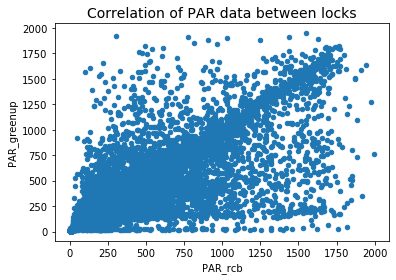

In [430]:
fig, ax = plt.subplots()
locks_par.plot.scatter(ax=ax,x='PAR_rcb',y='PAR_greenup')
ax.set_title("Correlation of PAR data between locks",fontsize=14)

#### Get Sonde deployment data

In [431]:
sonde_deployments = pd.read_csv('data/Greenup/sonde_deployment_data.csv',encoding='latin1')
sonde_deployments = sonde_deployments.drop(sonde_deployments.columns[9:],axis=1)
sonde_deployments = sonde_deployments.dropna(thresh=6)
#sonde_deployments.columns

#### Index with Date-Time

In [432]:
def datetime_sonde2(row):
    pattern = '%m/%d/%y-%H:%M:%S'
    dt = row['Date ']+'-'+row['Time']
    return pd.to_datetime(time.mktime(time.strptime(dt,pattern)),unit='s')
    
sonde_deployments['Date-Time'] = sonde_deployments.apply(lambda row: datetime_sonde2(row),axis=1)
sonde_deployments = sonde_deployments.set_index(['Date-Time'])
rcb_sonde_deployments = sonde_deployments[sonde_deployments['Location ']=='RCB']
greenup_sonde_deployments = sonde_deployments[sonde_deployments['Location ']=='Greenup']

#### Disable scrolling for time series plots

In [433]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Interactive timeseries plots for Sonde data, including transect data and sonde deployments

In [434]:
def plot_ts_all(Site='Both',date_range=(start_date,end_date)):
    fig, axes = plt.subplots(nrows=len(locks_all_dataonly.columns)+1,ncols=1,figsize=(20,60),sharex=False)
    i = 0
    for property in locks_all_dataonly.columns:
        if ((Site=='RCB') | (Site=='Both')):
            rcb_dataonly[property].plot(ax=axes[i],drawstyle='steps-post',legend=True,color='blue')
        if ((Site=='Greenup') | (Site=='Both')):
            greenup_dataonly[property].plot(ax=axes[i],drawstyle='steps-post',legend=True,color='green')
        if ((property!='Discharge CFS') & (property!='Depth m')):
            transects_combined[property].plot(ax=axes[i],color='red',marker='o',linestyle='',ms=2)
        if (Site=='Both'):
            axes[i].legend([property+' at RCB',property+' at Greenup',property+' at transects'],loc='upper left')
        else:
            axes[i].legend([property+' at '+Site,property+' at transects'],loc='upper left')
        axes[i].set_xlim(date_range)
        i = i+1
        
    if ((Site=='RCB') | (Site=='Both')):
        rcb_sonde_deployments['Sonde in Place Now'].plot(ax=axes[i],drawstyle='steps',color='blue')
    if ((Site=='Greenup') | (Site=='Both')):
        greenup_sonde_deployments['Sonde in Place Now'].plot(ax=axes[i],drawstyle='steps',color='green')
    if (Site=='Both'):
        axes[i].legend(['Sonde in place at RCB','Sonde in place at Greenup'],loc='upper left')
    else:
        axes[i].legend(['Sonde in Place at '+Site],loc='upper left')
    axes[i].set_xlim(date_range)
    axes[i].set_ylim(0,5.0)
    
interact_manual(plot_ts_all,Site=['RCB','Greenup','Both'],date_range=date_range_slider)

interactive(children=(Dropdown(description='Site', index=2, options=('RCB', 'Greenup', 'Both'), value='Both'),…

<function __main__.plot_ts_all(Site='Both', date_range=(datetime.datetime(2017, 8, 1, 0, 0), datetime.datetime(2019, 8, 5, 13, 51, 11, 703220)))>

### Timeseries plots for PAR data, including transects

In [435]:
def plot_ts_par(Site='Both',date_range=(start_date,end_date)):
    fig, ax = plt.subplots(figsize=(20,5))
    if ((Site=='RCB') | (Site=='Both')):
        locks_par['PAR_rcb'].plot(ax=ax,marker='o',linestyle='',ms=1,legend=True,color='blue')
    if ((Site=='Greenup') | (Site=='Both')):
        locks_par['PAR_greenup'].plot(ax=ax,marker='o',linestyle='',ms=1,legend=True,color='green')
    transects_combined['PAR'].plot(ax=ax,color='red',marker='o',linestyle='',ms=2)
    if (Site=='Both'):
        ax.legend(['PAR at RCB','PAR at Greenup','PAR at transects'],loc='upper left')
    else:
        ax.legend(['PAR at '+Site,'PAR at transects'],loc='upper left')
    ax.set_xlim(date_range)
    
interact(plot_ts_par,Site=['RCB','Greenup','Both'],date_range=date_range_slider)

interactive(children=(Dropdown(description='Site', index=2, options=('RCB', 'Greenup', 'Both'), value='Both'),…

<function __main__.plot_ts_par(Site='Both', date_range=(datetime.datetime(2017, 8, 1, 0, 0), datetime.datetime(2019, 8, 5, 13, 51, 11, 703220)))>

### Resample timeseries data

In [436]:
rcb_daily_means = rcb_dataonly.resample('6H').mean()
greenup_daily_means = greenup_dataonly.resample('6H').mean()
locks_par_means = locks_par.resample('6H').mean()
usgs_gage_means = usgs_gage.resample('6H').mean()
transects_daily = transects_combined.resample('6H')
transects_daily_means = transects_daily.mean()
transects_daily_max = transects_daily.max()
transects_daily_min = transects_daily.min()

### TODO: 
 * Add PAR data
 * Create time-series plot similar the ones below, but provide interactive menus for
   * Property to plot
   * RCB, Greenup, or Both
   * Options to include (if available):
     * Ironton gage data
     * Transects
     * Sonde deployments

In [437]:
def plot_ts_all(Site='Both',date_range=(start_date,end_date)):
    fig, axes = plt.subplots(nrows=len(locks_all_dataonly.columns)+2,ncols=1,figsize=(20,60),sharex=False)
    i = 0
    for property in locks_all_dataonly.columns:
        if (property=='Discharge CFS'):
            usgs_gage_means['Discharge'].plot(ax=axes[i],drawstyle='steps-post',legend=True,color='orange')                        
        else:
            if ((Site=='RCB') | (Site=='Both')):
                rcb_daily_means[property].plot(ax=axes[i],drawstyle='steps-post',legend=True,color='blue')
            if ((Site=='Greenup') | (Site=='Both')):
                greenup_daily_means[property].plot(ax=axes[i],drawstyle='steps-post',legend=True,color='green')
        if ((property!='Discharge CFS') & (property!='Depth m')):
            transects_daily_means[property].plot(ax=axes[i],color='red',marker='o',linestyle='',ms=4)
            transects_daily_max[property].plot(ax=axes[i],color='red',marker='+',linestyle='',ms=4)
            transects_daily_min[property].plot(ax=axes[i],color='red',marker='+',linestyle='',ms=4)
            for k, row in transects_daily_means.iterrows():
                if (math.isfinite(row[property])):
                    axes[i].text(k, row[property], str(int(row['T Pos'])), fontsize=12)
        if (property=='Discharge CFS'):
            axes[i].legend(['Discharge CFS at Ironton'],loc='upper left')            
        elif (Site=='Both'):
            axes[i].legend([property+' at RCB',property+' at Greenup',property+' at transects'],loc='upper left')
        else:
            axes[i].legend([property+' at '+Site,property+' at transects'],loc='upper left')
        axes[i].set_xlim(date_range)
        i = i+1
        
    if ((Site=='RCB') | (Site=='Both')):
        locks_par_means['PAR_rcb'].plot(ax=axes[i],marker='o',linestyle='',ms=2,legend=True,color='blue')
    if ((Site=='Greenup') | (Site=='Both')):
        locks_par_means['PAR_greenup'].plot(ax=axes[i],marker='o',linestyle='',ms=2,legend=True,color='green')  
    transects_daily_means['PAR'].plot(ax=axes[i],color='red',marker='o',linestyle='',ms=4)
    transects_daily_max['PAR'].plot(ax=axes[i],color='red',marker='+',linestyle='',ms=4)
    transects_daily_min['PAR'].plot(ax=axes[i],color='red',marker='+',linestyle='',ms=4)
    for k, row in transects_daily_means.iterrows():
        if (math.isfinite(row['PAR'])):
            axes[i].text(k, row['PAR'], str(int(row['T Pos'])), fontsize=12)

    if (Site=='Both'):
        axes[i].legend(['PAR at RCB','PAR at Greenup','PAR at transects'],loc='upper left')
    else:
        axes[i].legend(['PAR at '+Site,'PAR at transects'],loc='upper left')
    axes[i].set_xlim(date_range)
    i = i+1
        
    if ((Site=='RCB') | (Site=='Both')):
        rcb_sonde_deployments['Sonde in Place Now'].plot(ax=axes[i],drawstyle='steps',color='blue')
    if ((Site=='Greenup') | (Site=='Both')):
        greenup_sonde_deployments['Sonde in Place Now'].plot(ax=axes[i],drawstyle='steps',color='green')
    if (Site=='Both'):
        axes[i].legend(['Sonde in place at RCB','Sonde in place at Greenup'],loc='upper left')
    else:
        axes[i].legend(['Sonde in Place at '+Site],loc='upper left')
    axes[i].set_xlim(date_range)
    axes[i].set_ylim(0,5.0)
    
interact_manual(plot_ts_all,Site=['RCB','Greenup','Both'],date_range=date_range_slider)

interactive(children=(Dropdown(description='Site', index=2, options=('RCB', 'Greenup', 'Both'), value='Both'),…

<function __main__.plot_ts_all(Site='Both', date_range=(datetime.datetime(2017, 8, 1, 0, 0), datetime.datetime(2019, 8, 5, 13, 51, 11, 703220)))>

## Merge RCB and Greenup daily means

In [438]:
merge_rcb_greenup = pd.merge(rcb_daily_means, greenup_daily_means, how='outer', left_index=True, right_index=True, suffixes=('_rcb','_greenup'))
merge_rcb_greenup.to_csv("data/Greenup/locks_daily_means.csv")

### Cross correlation between RC Byrd and Greenup Locks readings

In [439]:
def scatter_plot_cross_timeseries(Property,CProperty,ColorMap='jet'):
    fig, ax = plt.subplots()
    merge_rcb_greenup.plot.scatter(ax=ax,x=Property+'_rcb',y=Property+'_greenup',c=CProperty+'_rcb',cmap=ColorMap,s=1)
    ax.set_title("Correlation of "+Property+" at RCB and Greenup Locks",fontsize=14)
    
interact(scatter_plot_cross_timeseries, \
         Property=locks_all_dataonly.columns, \
         CProperty=locks_all_dataonly.columns, \
         ColorMap=['jet','viridis','magma','coolwarm','seismic','Greys','Reds','Blues'] \
        )

interactive(children=(Dropdown(description='Property', options=('ODO mg/L', 'Chlorophyll µg/L', 'BGA-PC µg/L',…

<function __main__.scatter_plot_cross_timeseries(Property, CProperty, ColorMap='jet')>

## Merge Locks and USGS Gage data
 * TODO: 
   * Only merge Discharge data until issues (column mismatches) are resolved
   * Estimate Locks discharge from Ironton gage data
   * Move this up after reading Locks data

In [440]:
merge_locks_usgs = pd.merge(merge_rcb_greenup, usgs_gage_means, how='outer', left_index=True, right_index=True)
merge_locks_usgs.to_csv("data/Greenup/locks_usgs_daily_means.csv")

### Correlation between Locks and Ironton gage data

In [441]:
def scatter_plot_cross_all_timeseries(YProperty,XProperty,CProperty,ColorMap='jet'):
    fig, ax = plt.subplots()
    merge_locks_usgs.plot.scatter(ax=ax,x=XProperty,y=YProperty,c=CProperty,cmap=ColorMap,s=1)
    ax.set_title("RCB and Greenup Locks vs Ironton Gage",fontsize=14)
    
interact(scatter_plot_cross_all_timeseries, \
         YProperty=merge_rcb_greenup.drop(['Discharge CFS_rcb','Discharge CFS_greenup'],axis=1).columns, \
         XProperty=usgs_gage_means.columns, \
         CProperty=merge_locks_usgs.drop(['Discharge CFS_rcb','Discharge CFS_greenup'],axis=1).columns, \
         ColorMap=['jet','viridis','magma','coolwarm','seismic','Greys','Reds','Blues'] \
        )

interactive(children=(Dropdown(description='YProperty', options=('ODO % sat_rcb', 'ODO mg/L_rcb', 'Chlorophyll…

<function __main__.scatter_plot_cross_all_timeseries(YProperty, XProperty, CProperty, ColorMap='jet')>

## Merge Locks Sonde and PAR, and USGS gage data

In [442]:
merge_locks_par_usgs = pd.merge(merge_locks_usgs, locks_par_means, how='outer', left_index=True, right_index=True)
merge_locks_par_usgs.to_csv("data/Greenup/locks_par_usgs_daily_means.csv")

In [443]:
def scatter_plot_locks_par_usgs(YProperty,XProperty,CProperty,ColorMap='jet'):
    fig, ax = plt.subplots()
    merge_locks_par_usgs.plot.scatter(ax=ax,x=XProperty,y=YProperty,c=CProperty,cmap=ColorMap,s=1)
    ax.set_title("RCB and Greenup Locks vs Ironton Gage",fontsize=14)
    
interact(scatter_plot_locks_par_usgs, \
         YProperty=merge_locks_par_usgs.drop(['Discharge CFS_rcb','Discharge CFS_greenup'],axis=1).columns, \
         XProperty=merge_locks_par_usgs.drop(['Discharge CFS_rcb','Discharge CFS_greenup'],axis=1).columns, \
         CProperty=merge_locks_par_usgs.drop(['Discharge CFS_rcb','Discharge CFS_greenup'],axis=1).columns, \
         ColorMap=['jet','viridis','magma','coolwarm','seismic','Greys','Reds','Blues'] \
        )

interactive(children=(Dropdown(description='YProperty', options=('ODO % sat_rcb', 'ODO mg/L_rcb', 'Chlorophyll…

<function __main__.scatter_plot_locks_par_usgs(YProperty, XProperty, CProperty, ColorMap='jet')>

## Merge transects with locks and gage data 

In [444]:
merge_all = pd.merge(merge_locks_par_usgs, transects_daily_means, how='outer', left_index=True, right_index=True)
merge_all.to_csv("data/Greenup/merge_all.csv")
#merge_all.columns

### Correlation of transects with locks data

In [445]:
def scatter_plot_all(Property='Chlorophyll RFU'):
    fig, ax = plt.subplots()
    merge_all.plot.scatter(ax=ax,x=Property,y=Property+'_rcb',color='blue')
    merge_all.plot.scatter(ax=ax,x=Property,y=Property+'_greenup',color='green')
    ax.set_title("Correlation of "+Property+" at Transects and Greenup (green) and RCB (blue) Locks",fontsize=14)
    ax.set_xlabel(Property+" at Transects")
    ax.set_ylabel(Property+" at Locks")
    
interact(scatter_plot_all, \
         Property=locks_all_dataonly.drop(['Discharge CFS','Depth m'],axis=1).columns.tolist()+['PAR'] \
        )

interactive(children=(Dropdown(description='Property', options=('ODO mg/L', 'Chlorophyll µg/L', 'BGA-PC µg/L',…

<function __main__.scatter_plot_all(Property='Chlorophyll RFU')>

#### Generate means of resampled data as baseline and mean values and save (used to create transects_with_bases above)
#### [Suppress before publishing as Tool]
#### TODO: Move all timeseries processing to get baseline before processing transects

In [446]:
merge_all_byTPos = merge_all.groupby(['T Pos'])
merge_all_means = merge_all_byTPos.mean()
merge_all_means.to_csv('data/Greenup/merge_all_means.csv')
#merge_all_means.columns